In [1]:
%pip install --upgrade poutyne
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from poutyne import Model, EpochProgressionCallback, BestModelRestore
import torchmetrics

plt.rcParams["figure.dpi"] = 150

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 6.7 MB/s eta 0:00:00


Some constants we will need.

In [2]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

batch_size = 32
learning_rate = 0.001
num_epochs = 100
log_every_n_epochs = 10

Let's load some dataset from scikit-learn and get the description.

In [3]:
california = fetch_california_housing()
print(california.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [4]:
california_df = pd.DataFrame(california.data,
                             columns=california.feature_names)
california_df['MedHouseValue'] = pd.Series(california.target)
california_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [5]:
california_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Visualize data for two features

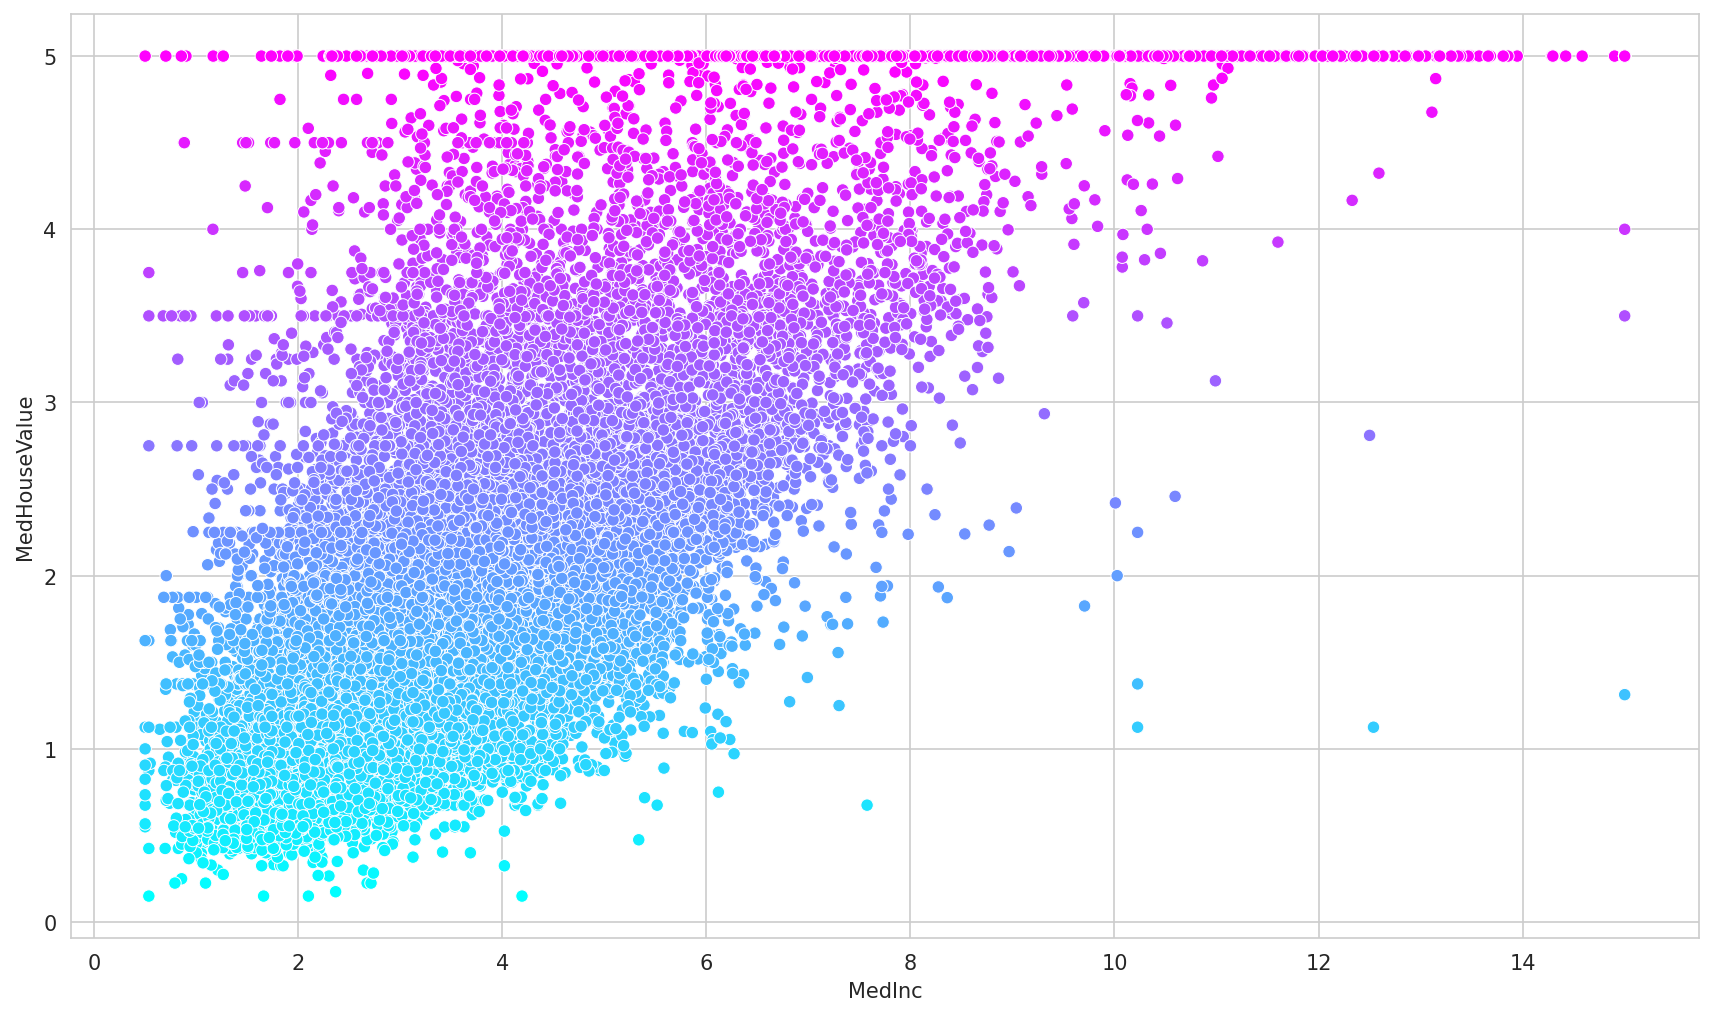

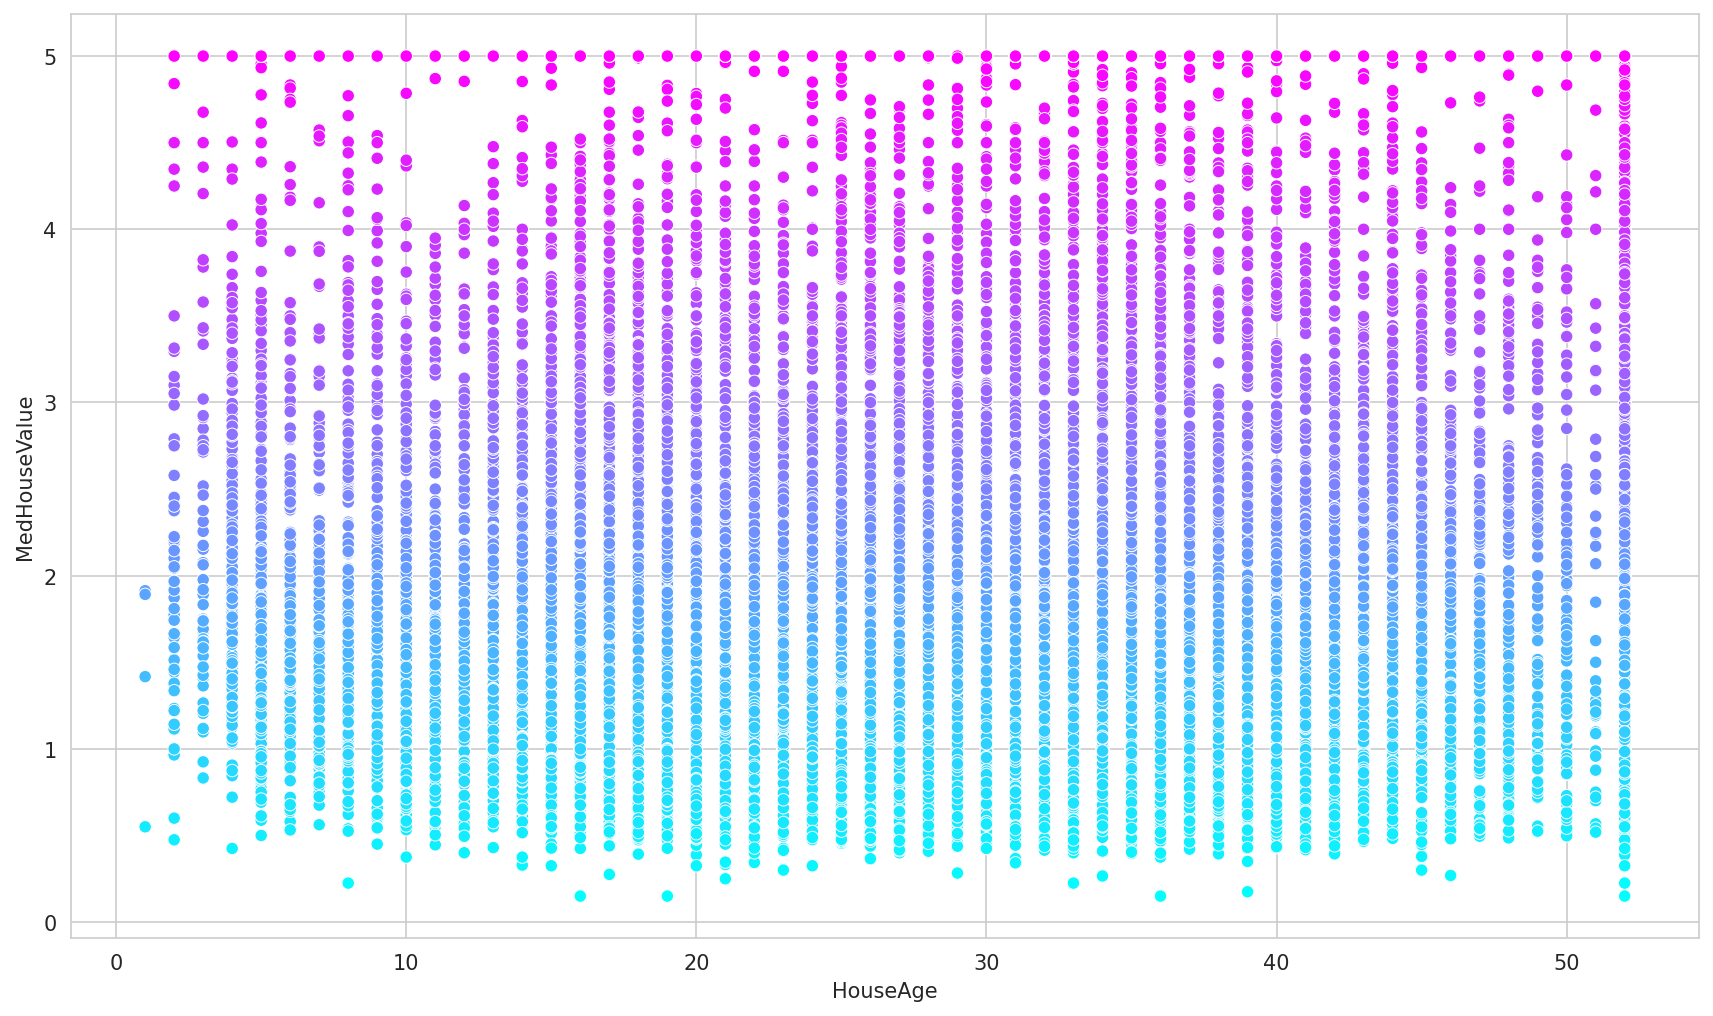

In [6]:
sns.set_style('whitegrid')

features = ['MedInc', 'HouseAge']
for feature in features:
    plt.figure(figsize=(14, 8))
    sns.scatterplot(data=california_df, x=feature,y='MedHouseValue',
                    hue='MedHouseValue', palette='cool', legend=False)

sns.set(font_scale=2)
sns.set_style('whitegrid')

for feature in california.feature_names:
    plt.figure(figsize=(16, 9))
    sns.scatterplot(data=sample_df, x=feature,y='MedHouseValue',
                    hue='MedHouseValue', palette='cool', legend=False)

In [7]:
X, y = fetch_california_housing(return_X_y=True)
X = X.astype("float32")
y = y.astype("float32")
num_features = X.shape[1]
X.shape, y.shape

((20640, 8), (20640,))

In [8]:
X

array([[   8.3252   ,   41.       ,    6.984127 , ...,    2.5555556,
          37.88     , -122.23     ],
       [   8.3014   ,   21.       ,    6.2381372, ...,    2.1098418,
          37.86     , -122.22     ],
       [   7.2574   ,   52.       ,    8.288136 , ...,    2.80226  ,
          37.85     , -122.24     ],
       ...,
       [   1.7      ,   17.       ,    5.2055426, ...,    2.3256352,
          39.43     , -121.22     ],
       [   1.8672   ,   18.       ,    5.329513 , ...,    2.1232092,
          39.43     , -121.32     ],
       [   2.3886   ,   16.       ,    5.254717 , ...,    2.616981 ,
          39.37     , -121.24     ]], dtype=float32)

In [9]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894], dtype=float32)

Let's split our data. For neural networks, we need 3 datasets: training, validation and testing datasets.

In [10]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42
)

scaler = StandardScaler()
X_train_valid = scaler.fit_transform(X_train_valid)
X_test = scaler.transform(X_test)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, train_size=0.75, random_state=42
)

In [11]:
print("Training set shapes (X, y):", X_train.shape, y_train.shape)
print("Validation set shapes (X, y):", X_valid.shape, y_valid.shape)
print("Testing set shapes (X, y):", X_test.shape, y_test.shape)

Training set shapes (X, y): (12384, 8) (12384,)
Validation set shapes (X, y): (4128, 8) (4128,)
Testing set shapes (X, y): (4128, 8) (4128,)


Now, we will train neural networks using the PyTorch library.

In [12]:
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_dataset = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [13]:
def pytorch_train_one_epoch(pytorch_network, optimizer, loss_function):
    """
    Trains the neural network for one epoch on the train DataLoader.

    Args:
        pytorch_network (torch.nn.Module): The neural network to train.
        optimizer (torch.optim.Optimizer): The optimizer of the neural network
        loss_function: The loss function.

    Returns:
        A tuple (loss, accuracy) corresponding to an average of the losses and
        an average of the accuracy, respectively, on the train DataLoader.
    """
    pytorch_network.train(True)
    with torch.enable_grad():
        loss_sum = 0.0
        example_count = 0
        for (x, y) in train_loader:
            # Transfer batch on GPU if needed.
            x = x.to(device)
            y = y.to(device)

            # We need to zero the gradient before every batch because the new
            # gradients would otherwise be summed with the previous gradients.
            optimizer.zero_grad()

            # Compute the predictions of the neural network on the batch.
            y_pred = pytorch_network(x)

            loss = loss_function(y_pred, y)

            # Do the the backpropagation to compute the gradients of the parameters.
            loss.backward()

            # Update our parameters with the gradient.
            optimizer.step()

            # Since the loss and accuracy are averages for the batch, we multiply
            # them by the the number of examples so that we can do the right
            # averages at the end of the epoch.
            loss_sum += float(loss) * len(x)
            example_count += len(x)

    avg_loss = loss_sum / example_count
    return avg_loss


def pytorch_test(pytorch_network, loader, loss_function):
    """
    Tests the neural network on a DataLoader.

    Args:
        pytorch_network (torch.nn.Module): The neural network to test.
        loader (torch.utils.data.DataLoader): The DataLoader to test on.
        loss_function: The loss function.

    Returns:
        A tuple (loss, accuracy) corresponding to an average of the losses and
        an average of the accuracy, respectively, on the DataLoader.
    """
    pytorch_network.eval()
    with torch.no_grad():
        loss_sum = 0.0
        example_count = 0
        for (x, y) in loader:
            # Transfer batch on GPU if needed.
            x = x.to(device)
            y = y.to(device)

            y_pred = pytorch_network(x)
            loss = loss_function(y_pred, y)

            # Since the loss and accuracy are averages for the batch, we multiply
            # them by the the number of examples so that we can do the right
            # averages at the end of the test.
            loss_sum += float(loss) * len(x)
            example_count += len(x)

    avg_loss = loss_sum / example_count
    return avg_loss


def pytorch_train(pytorch_network):
    """
    This function transfers the neural network to the right device,
    trains it for a certain number of epochs, tests at each epoch on
    the validation set and outputs the results on the test set at the
    end of training.

    Args:
        pytorch_network (torch.nn.Module): The neural network to train.
    """
    print("Network:")
    print(pytorch_network)
    print()

    # Transfer weights on GPU if needed.
    pytorch_network.to(device)

    loss_function = nn.MSELoss()
    optimizer = optim.Adam(pytorch_network.parameters(), lr=learning_rate)

    train_loss_list = []
    valid_loss_list = []
    for epoch in range(1, num_epochs + 1):
        # Training the neural network via backpropagation
        train_loss = pytorch_train_one_epoch(pytorch_network, optimizer, loss_function)

        # Validation at the end of the epoch
        valid_loss = pytorch_test(pytorch_network, valid_loader, loss_function)

        if epoch % log_every_n_epochs == 0:
            print(
                "Epoch {}/{}: loss: {}, val_loss: {}".format(
                    epoch, num_epochs, train_loss, valid_loss
                )
            )
        
        # Log training and validation loss
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)

    # Test at the end of the training
    test_loss = pytorch_test(pytorch_network, test_loader, loss_function)
    print("Test Loss: {}".format(test_loss))

    return train_loss_list, valid_loss_list

A simple regression.

Network:
Sequential(
  (0): Linear(in_features=8, out_features=1, bias=True)
  (1): Flatten(start_dim=0, end_dim=-1)
)

Epoch 10/100: loss: 0.5358945882905669, val_loss: 0.5599541155866874
Epoch 20/100: loss: 0.5158301717782205, val_loss: 0.5293981267731319
Epoch 30/100: loss: 0.515404048662161, val_loss: 0.5296685339868531
Epoch 40/100: loss: 0.5152951362675167, val_loss: 0.5294052410957425
Epoch 50/100: loss: 0.5156264089875751, val_loss: 0.5296617305093958
Epoch 60/100: loss: 0.5156183004071239, val_loss: 0.5298340303260226
Epoch 70/100: loss: 0.5155165963625723, val_loss: 0.5298569533945054
Epoch 80/100: loss: 0.5153788678174795, val_loss: 0.5287749145844186
Epoch 90/100: loss: 0.5157480545592247, val_loss: 0.5291580054187035
Epoch 100/100: loss: 0.5151670446152526, val_loss: 0.5319972387117933
Test Loss: 0.5673608872317528


<Axes: >

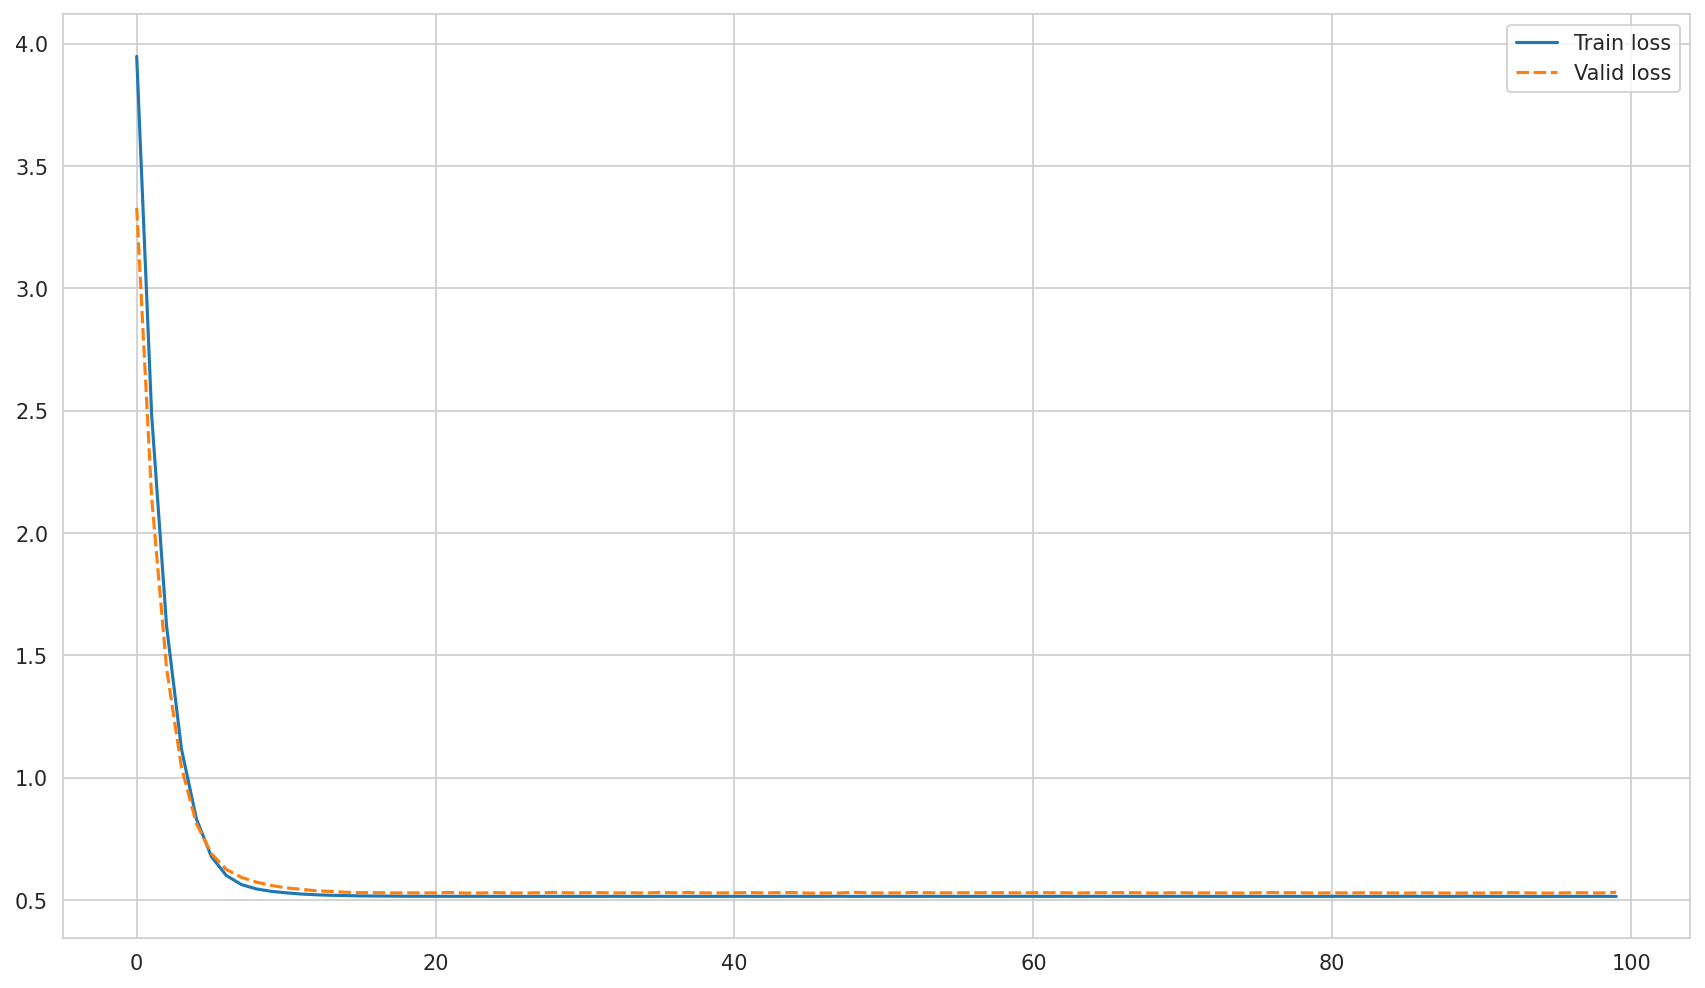

In [14]:
fc_net = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Flatten(0),
)
train_loss_1, valid_loss_1 = pytorch_train(fc_net)

df = pd.DataFrame({'Train loss':train_loss_1, 'Valid loss':valid_loss_1})
plt.figure(figsize=(14, 8))
sns.lineplot(data=df)

A neural network with 2 layers and no activation function.

Network:
Sequential(
  (0): Linear(in_features=8, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=1, bias=True)
  (2): Flatten(start_dim=0, end_dim=-1)
)

Epoch 10/100: loss: 0.5240213505211418, val_loss: 0.57221989148809
Epoch 20/100: loss: 0.5200221724904477, val_loss: 0.595351135314897
Epoch 30/100: loss: 0.5209928399447631, val_loss: 0.5407761381578076
Epoch 40/100: loss: 0.5205300888503861, val_loss: 0.5345382294220518
Epoch 50/100: loss: 0.5244848927632166, val_loss: 0.5457309757092202
Epoch 60/100: loss: 0.5203190019272402, val_loss: 0.5402698825265086
Epoch 70/100: loss: 0.5209209666772714, val_loss: 0.5365901882796325
Epoch 80/100: loss: 0.5186958533232834, val_loss: 0.5336903985156569
Epoch 90/100: loss: 0.518764193282879, val_loss: 0.5354580761388291
Epoch 100/100: loss: 0.5203524355124441, val_loss: 0.5327260205449984
Test Loss: 0.5697230448325475


<Axes: >

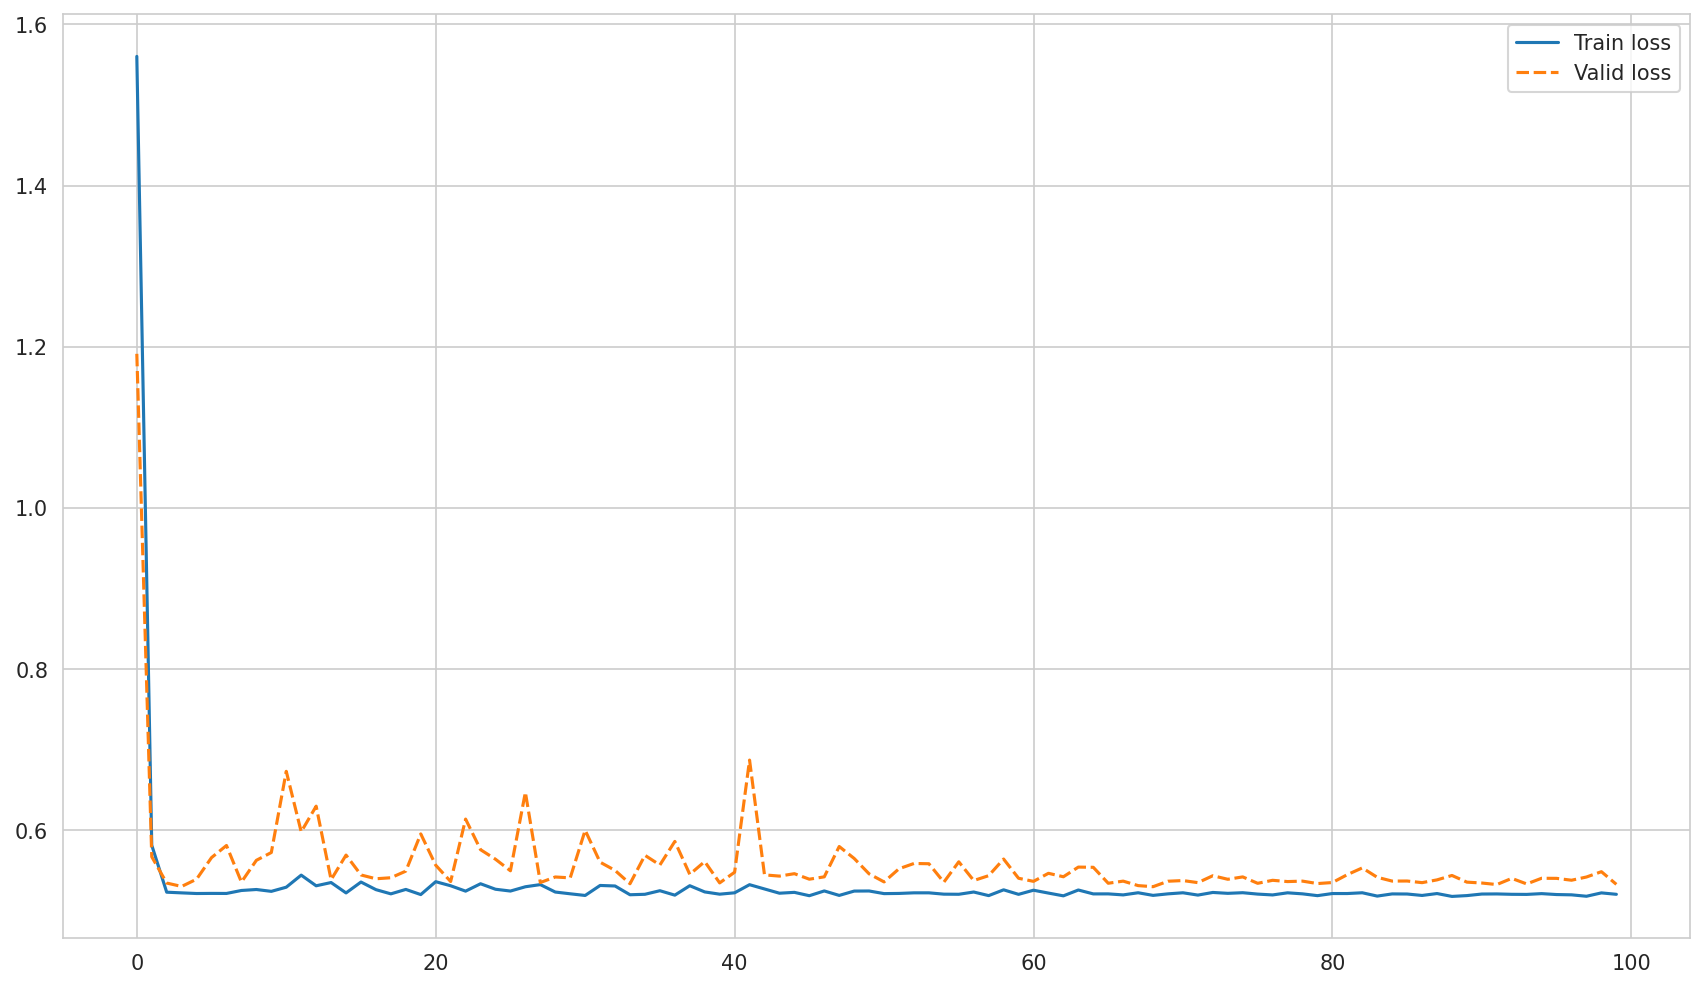

In [15]:
fc_net = nn.Sequential(
    nn.Linear(num_features, 100),
    nn.Linear(100, 1),
    nn.Flatten(0),
)
train_loss_2, valid_loss_2 = pytorch_train(fc_net)

df = pd.DataFrame({'Train loss':train_loss_2, 'Valid loss':valid_loss_2})
plt.figure(figsize=(14, 8))
sns.lineplot(data=df)

Let's add an activation function.

Network:
Sequential(
  (0): Linear(in_features=8, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
  (3): Flatten(start_dim=0, end_dim=-1)
)

Epoch 10/100: loss: 0.3437200042705511, val_loss: 0.35694428850976073
Epoch 20/100: loss: 0.31831857045144996, val_loss: 0.37651123747576115
Epoch 30/100: loss: 0.3038563395462911, val_loss: 0.3254724981248841
Epoch 40/100: loss: 0.3094320246030502, val_loss: 0.3452065781105396
Epoch 50/100: loss: 0.29338837662370015, val_loss: 0.36329062958789426
Epoch 60/100: loss: 0.28576277456311294, val_loss: 0.31736789990303127
Epoch 70/100: loss: 0.28779731319317214, val_loss: 0.32926855940920435
Epoch 80/100: loss: 0.28047710093031863, val_loss: 0.3185417904525764
Epoch 90/100: loss: 0.282719951623555, val_loss: 0.3398396823872892
Epoch 100/100: loss: 0.2757808691617438, val_loss: 0.33949144785256347
Test Loss: 0.3079563814771268


<Axes: >

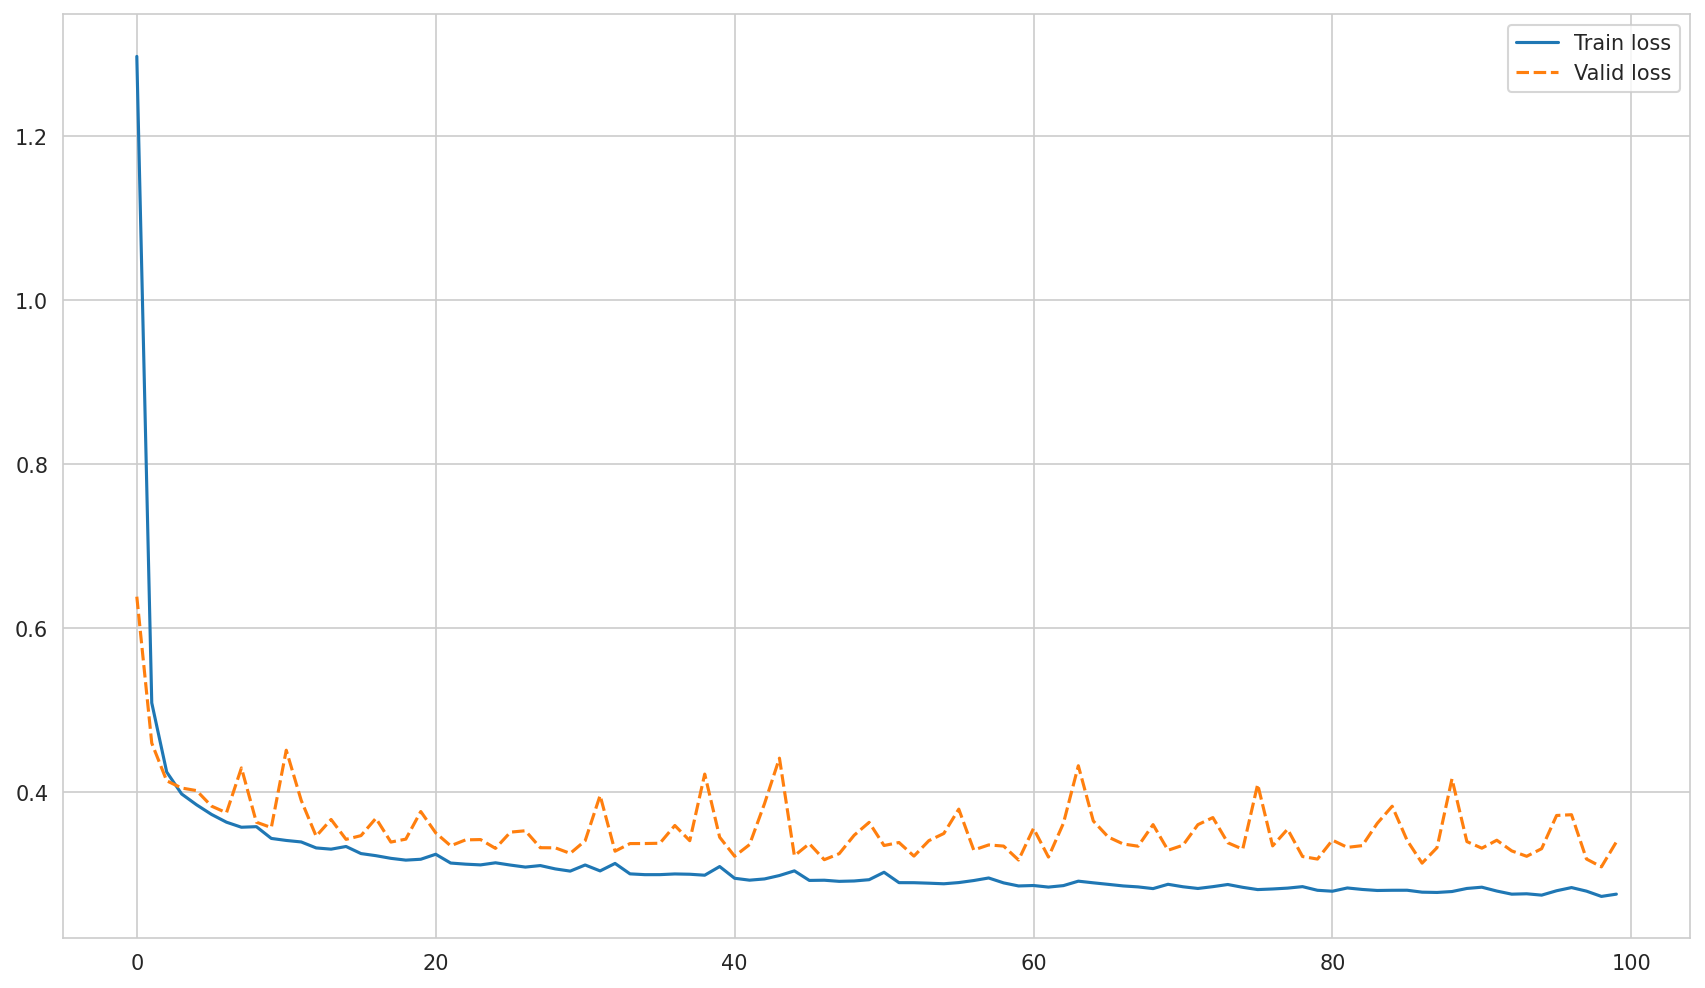

In [16]:
fc_net = nn.Sequential(
    nn.Linear(num_features, 100),
    nn.ReLU(),
    nn.Linear(100, 1),
    nn.Flatten(0),
)
train_loss_2_nn, valid_loss_2_nn = pytorch_train(fc_net)

df = pd.DataFrame({'Train loss':train_loss_2_nn, 'Valid loss':valid_loss_2_nn})
plt.figure(figsize=(14, 8))
sns.lineplot(data=df)

Let's add a third layer.

Network:
Sequential(
  (0): Linear(in_features=8, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
  (5): Flatten(start_dim=0, end_dim=-1)
)

Epoch 10/100: loss: 0.29828100391598633, val_loss: 0.3238154857080112
Epoch 20/100: loss: 0.2760901121514096, val_loss: 0.3041192646636519
Epoch 30/100: loss: 0.2613277025232019, val_loss: 0.2811532498214596
Epoch 40/100: loss: 0.2540754629467501, val_loss: 0.27899974492169166
Epoch 50/100: loss: 0.24624234857639293, val_loss: 0.2935772787692935
Epoch 60/100: loss: 0.23426772855241476, val_loss: 0.2676028628913007
Epoch 70/100: loss: 0.22451769310297584, val_loss: 0.27225683895192404
Epoch 80/100: loss: 0.2154673244948535, val_loss: 0.26342639973921367
Epoch 90/100: loss: 0.20746642296281895, val_loss: 0.26881536107885745
Epoch 100/100: loss: 0.20093319983791935, val_loss: 0.27274889640452327
Test Loss: 0.27278190169685573

<Axes: >

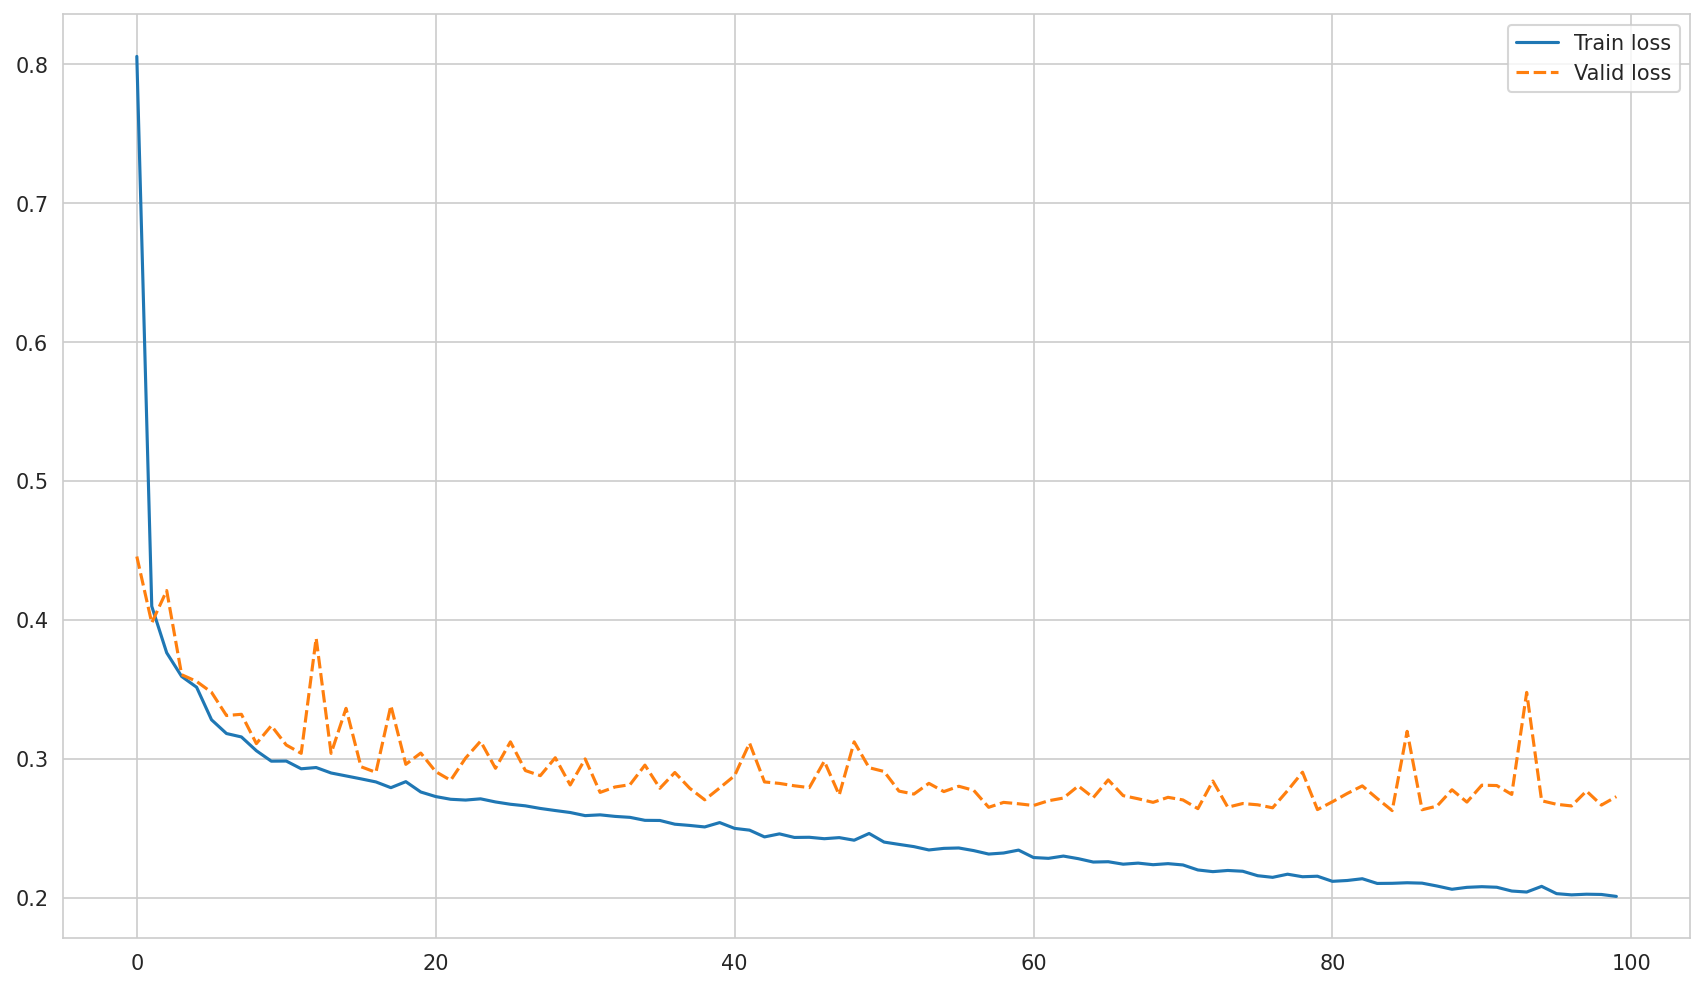

In [17]:
fc_net = nn.Sequential(
    nn.Linear(num_features, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 1),
    nn.Flatten(0),
)
train_loss_3_nn, valid_loss_3_nn = pytorch_train(fc_net)

df = pd.DataFrame({'Train loss':train_loss_3_nn, 'Valid loss':valid_loss_3_nn})
plt.figure(figsize=(14, 8))
sns.lineplot(data=df)

And a fourth.

Network:
Sequential(
  (0): Linear(in_features=8, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=1, bias=True)
  (7): Flatten(start_dim=0, end_dim=-1)
)

Epoch 10/100: loss: 0.29398118804668577, val_loss: 0.33139695100081984
Epoch 20/100: loss: 0.26170068540314373, val_loss: 0.30099723927041355
Epoch 30/100: loss: 0.24070550139406238, val_loss: 0.2785634696483612
Epoch 40/100: loss: 0.2207705233371227, val_loss: 0.2702579818261686
Epoch 50/100: loss: 0.20589522423477752, val_loss: 0.27523621275674465
Epoch 60/100: loss: 0.1906432564675962, val_loss: 0.28594045167745546
Epoch 70/100: loss: 0.17974426244079914, val_loss: 0.2759669773684916
Epoch 80/100: loss: 0.1701058080415085, val_loss: 0.2996449538095053
Epoch 90/100: loss: 0.16110008792321195, val_loss: 0.3109452472638714
Epoch 100/100: loss: 0.1521

<Axes: >

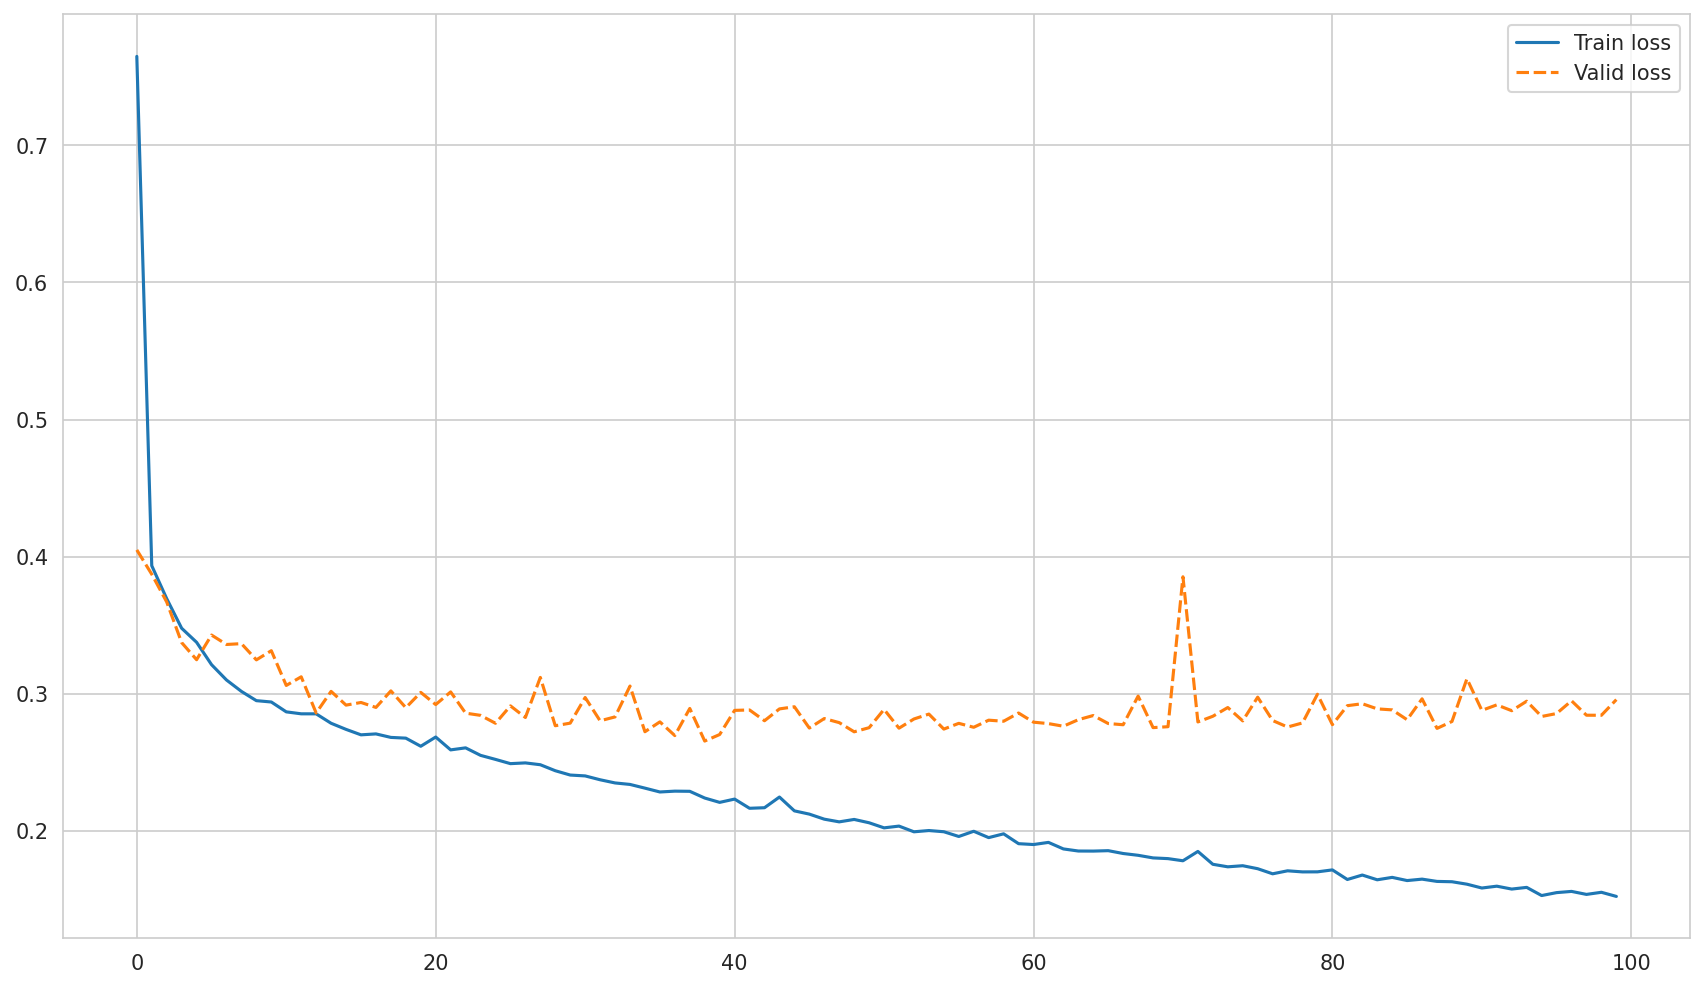

In [18]:
fc_net = nn.Sequential(
    nn.Linear(num_features, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 1),
    nn.Flatten(0),
)
train_loss_4_nn, valid_loss_4_nn = pytorch_train(fc_net)

df = pd.DataFrame({'Train loss':train_loss_4_nn, 'Valid loss':valid_loss_4_nn})
plt.figure(figsize=(14, 8))
sns.lineplot(data=df)

Visualize validation loss for all networks

<Axes: >

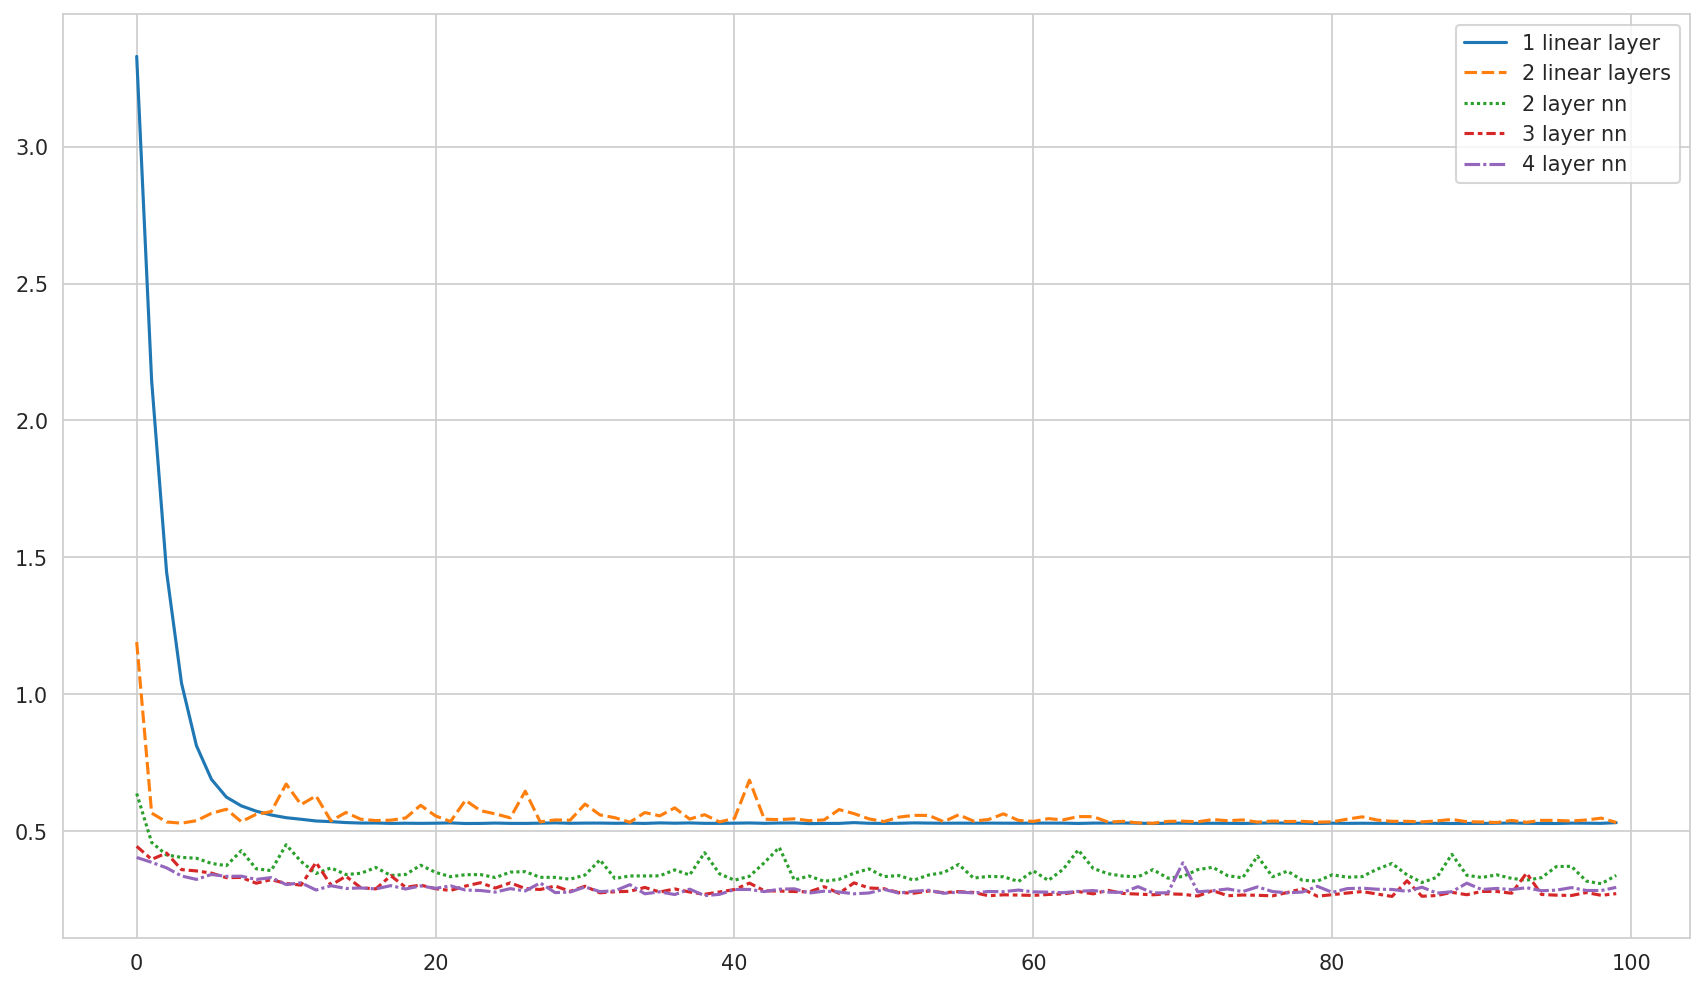

In [19]:
df = pd.DataFrame({'1 linear layer':valid_loss_1, '2 linear layers':valid_loss_2, '2 layer nn':valid_loss_2_nn, '3 layer nn':valid_loss_3_nn, '4 layer nn':valid_loss_4_nn})
plt.figure(figsize=(14, 8))
sns.lineplot(data=df)

Let's use the Poutyne library instead of our own functions.

In [20]:
def poutyne_train(pytorch_network):
    """
    This function creates a Poutyne Model (see https://poutyne.org/model.html), sends the Model
    on the specified device, and uses the `fit_generator` method to train the neural network.
    At the end, the `evaluate_generator` is used on  the test set.

    Args:
        pytorch_network (torch.nn.Module): The neural network to train.
    """
    print(pytorch_network)

    optimizer = optim.Adam(pytorch_network.parameters(), lr=learning_rate)
    loss_function = nn.MSELoss()

    # Poutyne Model on GPU
    model = Model(
        pytorch_network,
        optimizer,
        loss_function,
        batch_metrics=["l1", torchmetrics.R2Score()],
        device=device,
    )

    # Train
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),
        epochs=num_epochs,
        verbose=False,
        callbacks=[
            EpochProgressionCallback(show_every_n_epochs=log_every_n_epochs),
            # BestModelRestore(verbose=True)
        ],
    )

    # Test
    test_loss = model.evaluate(
        X_test, y_test, progress_options=dict(show_every_n_test_steps="none")
    )

    return history, test_loss

In [21]:
fc_net = nn.Sequential(
    nn.Linear(num_features, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 1),
    nn.Flatten(0),
)
history, test_loss = poutyne_train(fc_net)

Sequential(
  (0): Linear(in_features=8, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=1, bias=True)
  (7): Flatten(start_dim=0, end_dim=-1)
)
Epoch:  10/100 Train steps: 387 Val steps: 129 1.53s loss: 0.285117 l1: 0.368282 r2_score: 0.784754 val_loss: 0.322699 val_l1: 0.390004 val_r2_score: 0.764988
Epoch:  20/100 Train steps: 387 Val steps: 129 1.66s loss: 0.257507 l1: 0.347643 r2_score: 0.805598 val_loss: 0.286625 val_l1: 0.376428 val_r2_score: 0.791260
Epoch:  30/100 Train steps: 387 Val steps: 129 1.49s loss: 0.234422 l1: 0.330537 r2_score: 0.823025 val_loss: 0.275695 val_l1: 0.355300 val_r2_score: 0.799220
Epoch:  40/100 Train steps: 387 Val steps: 129 1.54s loss: 0.214606 l1: 0.315452 r2_score: 0.837985 val_loss: 0.296597 val_l1: 0.371903 val_r2_score: 0.783997
Epoch:  50/100 Train steps: 387 

Let's plot our losses and metrics.

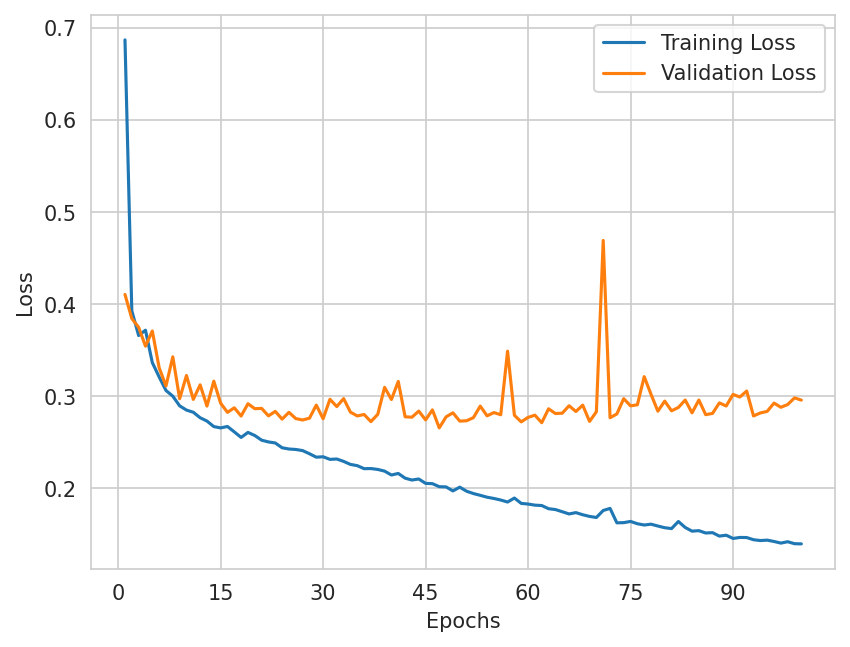

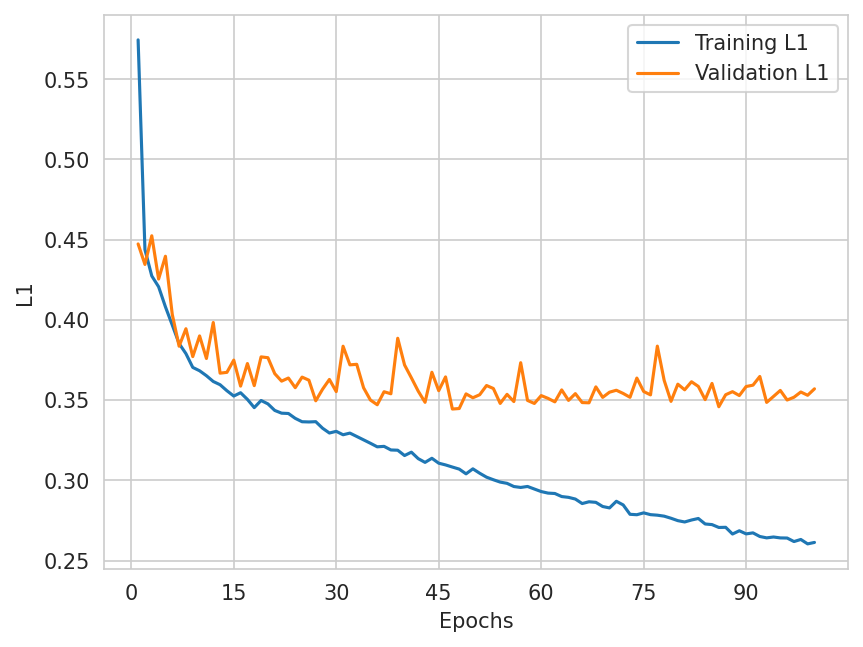

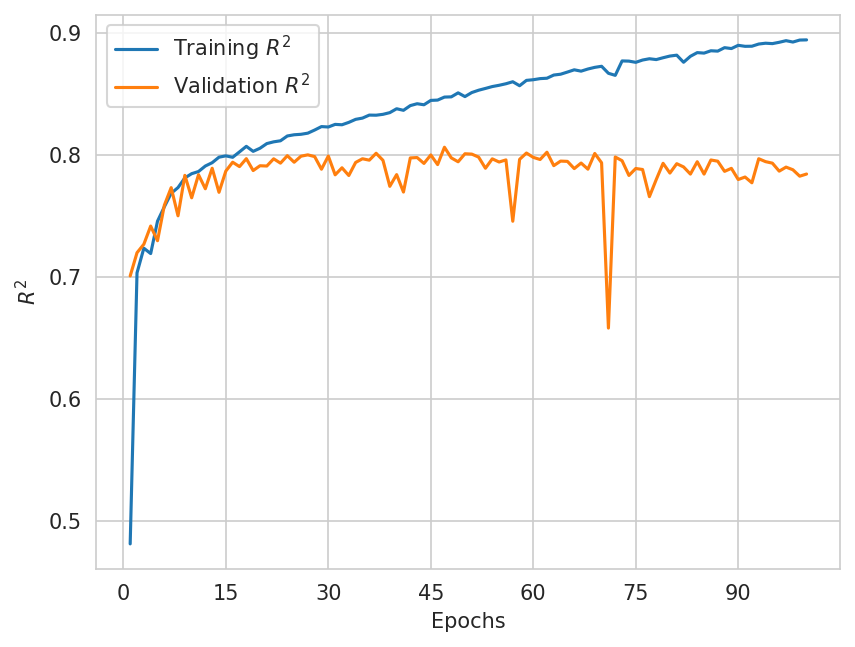

In [22]:
from poutyne import plot_history

plot_history(
    history, metrics=["loss", "l1", "r2_score"], labels=["Loss", "L1", "$R^2$"]
)
plt.show()

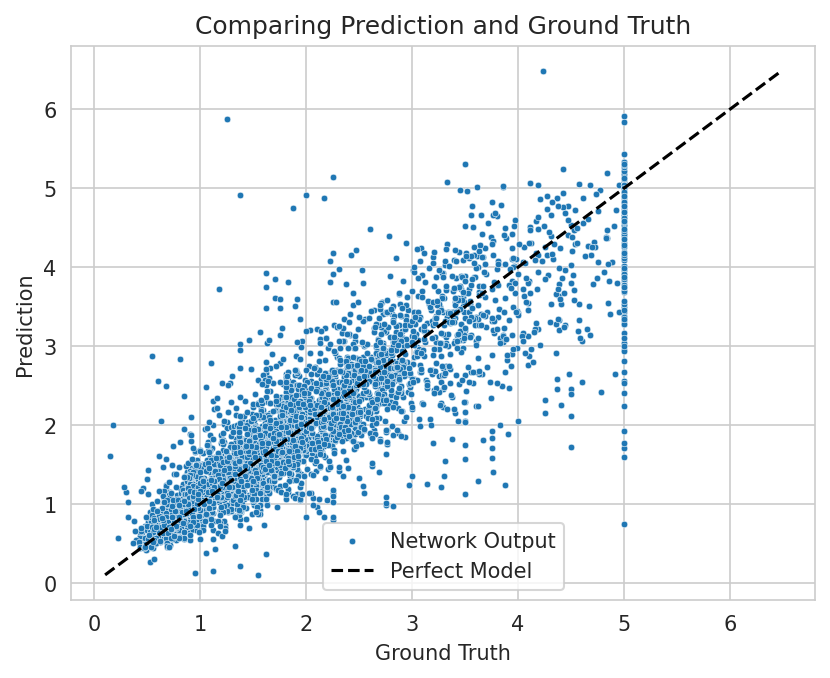

In [47]:
def plot_output(pytorch_network, loader):
    """
    Plots the neural network`s output and true targets.

    Args:
        pytorch_network (torch.nn.Module): The neural network to test.
        loader (torch.utils.data.DataLoader): The DataLoader to collect outputs on.
    """
    pytorch_network.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for (x, y) in loader:
            # Transfer batch on GPU if needed.
            x = x.to(device)

            y_pred_batch = pytorch_network(x)

            y_pred.extend(y_pred_batch.tolist())
            y_true.extend(y.tolist())

    sns.scatterplot(y=y_pred, x=y_true, label='Network Output', s=10)
    sns.lineplot(x=[min(y_pred), max(y_pred)], y=[min(y_pred), max(y_pred)], label='Perfect Model', linestyle='--', color='black')

    plt.ylabel('Prediction')
    plt.xlabel('Ground Truth')
    plt.title('Comparing Prediction and Ground Truth')

plot_output(fc_net, test_loader)

NameError: ignored